In [10]:
from skimage import measure
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [47]:
def compute_flatness_elongation(img, bg=None, spacing=(), verbose=False):
    """Compute flatness and elongation of a volumetric object.
    These are called "Shape factor": https://en.wikipedia.org/wiki/Shape_factor_%28image_analysis_and_microscopy%29#Elongation_shape_factor

    Parameters
    ----------
    img : numpy.ndarray
        Image array.
    bg : int, default=None
        Value of the background voxels. If bg is None then use the most frequent value.
    spacing : tuple, default=()
        Image spacing.
    verbose : boolean, default=False
        Whether to display information.
    """
    if bg is None:
        # compute volume with voxel
        labels = measure.label(img)
        unq,vol_voxel = np.unique(labels, return_counts=True)

        if len(unq)>2:
            print("[Warning] More than one object were found in the image. Number of connected components: {}".format(len(unq)-1))

        if verbose: print("Voxel volume:", vol_voxel[1:])

        # use the biggest volume as background
        bg = unq[np.argmax(vol_voxel)]

    # get foreground voxel coordinates
    fg = np.argwhere(img != bg)

    # compute barycenter and center the foreground voxels
    bary = np.mean(fg,axis=0)
    fg = fg - bary
    # fg = fg / np.sqrt(np.mean(fg*fg))

    # get the covariance matrix
    cov = fg.T.dot(fg)/len(fg)

    # other method:
    # m = measure.moments_central(img, order=2)
    # cov = np.array([
    #     [m[2,0,0], m[1,1,0], m[1,0,1]],
    #     [m[1,1,0], m[0,2,0], m[0,1,1]],
    #     [m[1,0,1], m[0,1,1], m[0,0,2]],
    # ])/m[0,0,0]

    # eventually resize image
    if len(spacing)>0:
        spacing = np.array(spacing)[::-1].reshape(1,3)
        cov = cov*(spacing.T.dot(spacing))

    # get the eigenvalues
    eigval, eigvect = np.linalg.eig(cov)
    # eigval = np.real(sorted(eigval))

    # compute flatness and elongation
    flatness = np.sqrt(sorted(eigval)[1]/sorted(eigval)[0])
    # elongation = np.sqrt(eigval[2]/eigval[1])

    return flatness, bary, np.sqrt(eigval), eigvect

In [75]:
image_path = "/home/george/data/xprize/samples_fb/crops/crop_20230908001619-00-06_CROPNUMBER_1_UUID_ChangeThisTEMPORARY.png"
im = Image.open(image_path)

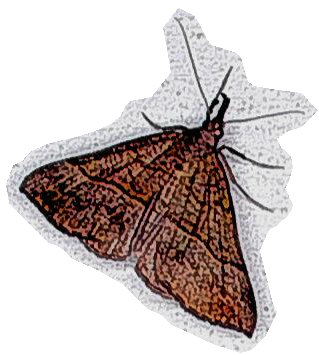

In [7]:
im

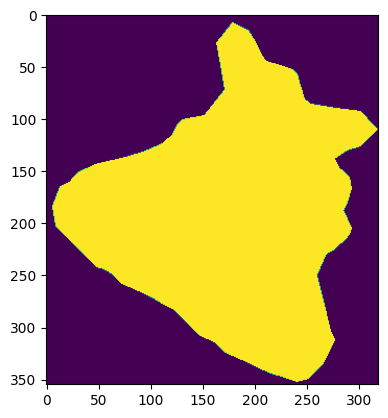

In [48]:
msk = np.array(im)
msk = msk[...,-1]
plt.imshow(msk)

In [58]:
msk.max()

255

In [60]:
flatness, bary, eigvals, eigvect=compute_flatness_elongation(msk, bg=0)
flatness, bary, eigvals, eigvect

(1.0787809082586706,
 array([191.2770499 , 176.08026713]),
 array([73.4494843 , 68.08563605]),
 array([[ 0.9794875 ,  0.20150493],
        [-0.20150493,  0.9794875 ]]))

In [62]:
np.sqrt(eigvect)

/tmp/ipykernel_2119381/1625028369.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(eigvect)


array([[0.98969061, 0.448893  ],
       [       nan, 0.98969061]])

(-0.260554548954939,
 1.0385371221923072,
 -0.04897437503882617,
 1.0284618758153494)

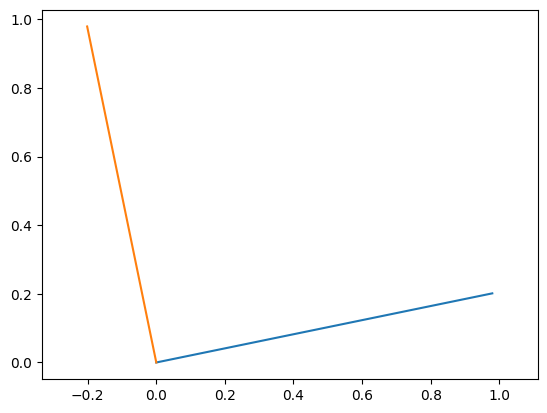

In [67]:
# v=eigvals*eigvect
v=eigvect
v0=np.vstack((np.zeros(2),v[0]))
v1=np.vstack((np.zeros(2),v[1]))
plt.plot(v0[:,0], v0[:,1])
plt.plot(v1[:,0],v1[:,1])
plt.axis('equal')

In [33]:
x1 = eigvals * eigvect + bary
x2 = - eigvals * eigvect + bary
x1, x2

(array([[257.96607939, 190.88070014],
        [177.55745874, 248.02311894]]),
 array([[124.5880204 , 161.27983412],
        [204.99664106, 104.13741532]]))

In [32]:
x

array([[257.96607939, 190.88070014],
       [177.55745874, 248.02311894]])

In [38]:
eigvect*+bary

array([[378.63052946, 211.5613086 ],
       [152.73378182, 348.54868792]])

In [43]:
np.vstack((bary, bary+eigvect[0]*eigvals[0]))

array([[191.2770499 , 176.08026713],
       [257.96607939, 189.79985829]])

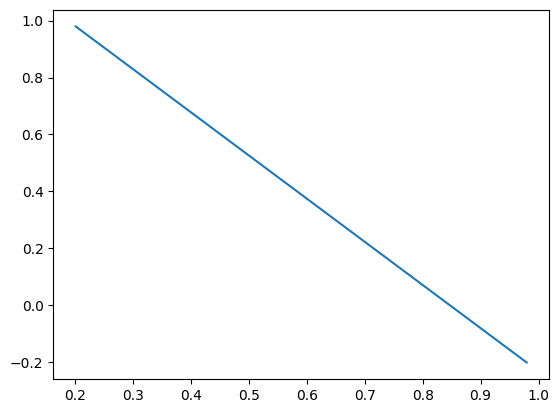

In [39]:
plt.plot(eigvect[0], eigvect[1])

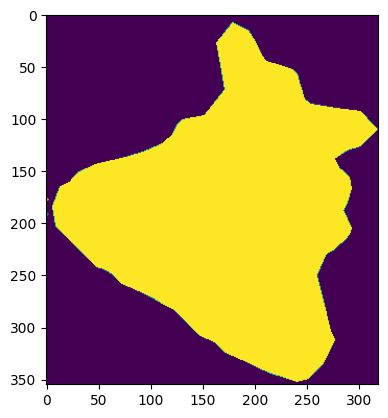

In [34]:
plt.imshow(msk)


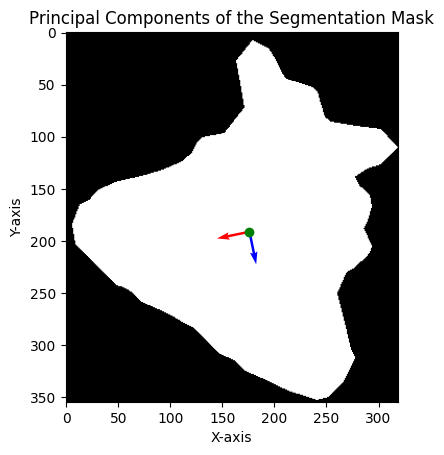

In [71]:
def find_image_moments(mask):
    y, x = np.nonzero(mask)
    moments = {}
    moments['m00'] = len(x)
    moments['m10'] = x.sum()
    moments['m01'] = y.sum()
    moments['m20'] = (x ** 2).sum()
    moments['m11'] = (x * y).sum()
    moments['m02'] = (y ** 2).sum()
    moments['mu20'] = moments['m20'] - (moments['m10'] ** 2) / moments['m00']
    moments['mu11'] = moments['m11'] - (moments['m10'] * moments['m01']) / moments['m00']
    moments['mu02'] = moments['m02'] - (moments['m01'] ** 2) / moments['m00']
    return moments

def compute_principal_components(mask):
    moments = find_image_moments(mask)
    
    # Calculate the centroid
    x_mean = moments['m10'] / moments['m00']
    y_mean = moments['m01'] / moments['m00']
    
    # Calculate covariance matrix
    cov_matrix = np.array([
        [moments['mu20'] / moments['m00'], moments['mu11'] / moments['m00']],
        [moments['mu11'] / moments['m00'], moments['mu02'] / moments['m00']]
    ])
    
    # Calculate eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(cov_matrix)
    
    return (x_mean, y_mean), eigvecs

def plot_principal_components(mask, centroid, principal_components):
    # Plot the segmentation mask
    plt.imshow(mask, cmap='gray')
    
    # Plot the principal components
    plt.quiver(centroid[0], centroid[1], principal_components[0, 0], principal_components[1, 0], color='r', scale=10)
    plt.quiver(centroid[0], centroid[1], principal_components[0, 1], principal_components[1, 1], color='b', scale=10)
    
    plt.scatter(centroid[0], centroid[1], color='g')
    
    plt.title("Principal Components of the Segmentation Mask")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

 # Compute principal components
centroid, principal_components = compute_principal_components(msk)

# Plot principal components
plot_principal_components(msk, centroid, principal_components)

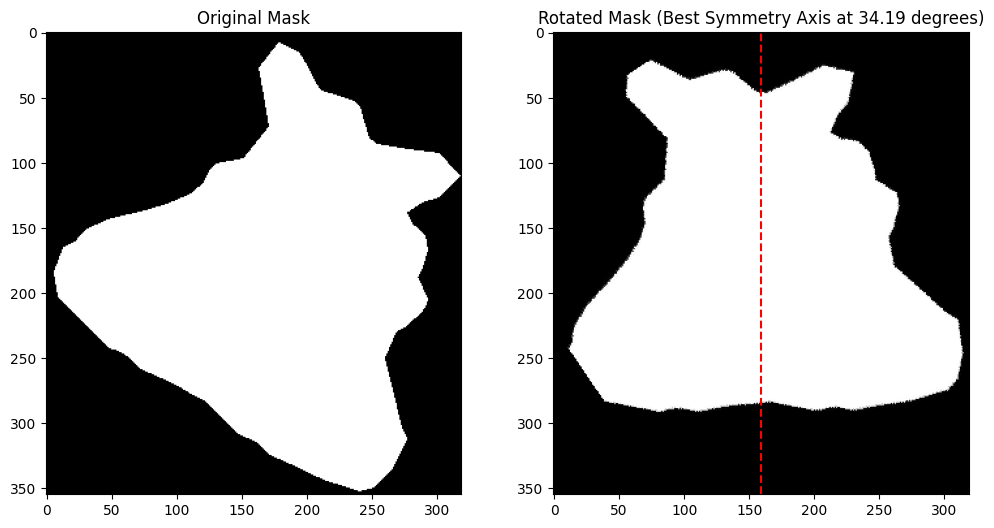

34.18994413407822

In [74]:
from scipy.ndimage import rotate, shift

def find_centroid(mask):
    y, x = np.nonzero(mask)
    x_mean = x.mean()
    y_mean = y.mean()
    return x_mean, y_mean

def calculate_symmetry_metric(mask, angle, centroid):
    # Shift the mask so that the centroid is at the center
    shifted_mask = shift(mask, shift=[mask.shape[0]//2 - centroid[1], mask.shape[1]//2 - centroid[0]])
    
    # Rotate the shifted mask
    rotated_mask = rotate(shifted_mask, angle, reshape=False, order=0)
    
    # Calculate the symmetry metric by comparing the two halves
    mid = rotated_mask.shape[1] // 2
    left_half = rotated_mask[:, :mid]
    right_half = np.flip(rotated_mask[:, mid:], axis=1)
    
    # Ensure the halves are the same shape
    min_cols = min(left_half.shape[1], right_half.shape[1])
    left_half = left_half[:, :min_cols]
    right_half = right_half[:, :min_cols]
    
    # Calculate the symmetry metric (e.g., mean squared error between the halves)
    symmetry_metric = np.sum((left_half - right_half) ** 2)
    
    return symmetry_metric

def find_best_symmetry_axis(mask):
    centroid = find_centroid(mask)
    best_angle = 0
    best_metric = float('inf')
    angles = np.linspace(0, 180, 180)  # Check angles from 0 to 180 degrees
    
    for angle in angles:
        metric = calculate_symmetry_metric(mask, angle, centroid)
        if metric < best_metric:
            best_metric = metric
            best_angle = angle
    
    return best_angle

def plot_symmetry_axis(mask, best_angle):
    centroid = find_centroid(mask)
    
    # Shift the mask so that the centroid is at the center
    shifted_mask = shift(mask, shift=[mask.shape[0]//2 - centroid[1], mask.shape[1]//2 - centroid[0]])
    
    # Rotate the shifted mask to align with the best symmetry axis
    rotated_mask = rotate(shifted_mask, best_angle, reshape=False, order=0)
    
    # Plot the original and rotated masks with the symmetry axis
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    axs[0].imshow(mask, cmap='gray')
    axs[0].set_title('Original Mask')
    
    axs[1].imshow(rotated_mask, cmap='gray')
    axs[1].axvline(x=rotated_mask.shape[1] // 2, color='r', linestyle='--')
    axs[1].set_title(f'Rotated Mask (Best Symmetry Axis at {best_angle:.2f} degrees)')
    
    plt.show()

# Find the best symmetry axis
best_angle = find_best_symmetry_axis(msk)

# Plot the symmetry axis
plot_symmetry_axis(msk, best_angle)

best_angle

## Run it on a folder

In [100]:
def find_centroid(mask):
    y, x = np.nonzero(mask)
    x_mean = x.mean()
    y_mean = y.mean()
    return x_mean, y_mean

fg = np.argwhere(msk != 0)

# compute barycenter and center the foreground voxels
bary = np.mean(fg,axis=0)

find_centroid(msk), bary

((176.08026713251084, 191.27704989627688), array([191.2770499 , 176.08026713]))

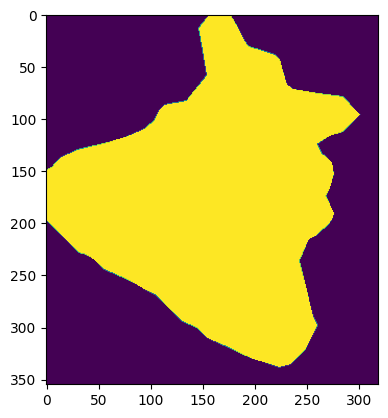

In [102]:
shifted_mask = 
plt.imshow(shifted_mask)

In [109]:
np.array(img.shape)//2

array([177, 159])

[[ 11 159]
 [312 159]]
[[177  20]
 [177 291]]
[[ 96.23227773 127.04860772]
 [348.14332365 -37.69915385]]
[[159.08043309 -80.13997635]
 [307.40815198 146.66365636]]
[[-29.72324523 222.18780069]
 [209.42248851  44.67472693]]


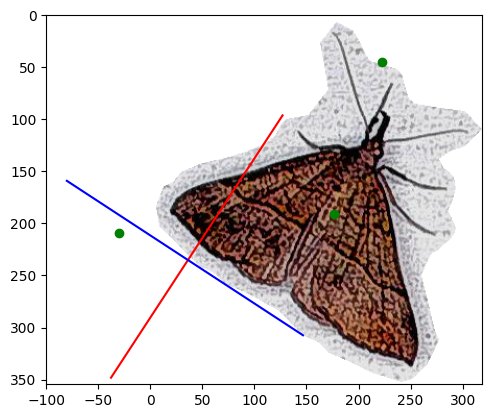

(301, 271)

In [147]:
import os
import threading

def find_centroid(mask):
    y, x = np.nonzero(mask)
    x_mean = x.mean()
    y_mean = y.mean()
    return x_mean, y_mean

def calculate_symmetry_metric(mask, angle, centroid):
    # Shift the mask so that the centroid is at the center
    shifted_mask = shift(mask, shift=[mask.shape[0]//2 - centroid[1], mask.shape[1]//2 - centroid[0]])
    
    # Rotate the shifted mask
    rotated_mask = rotate(shifted_mask, angle, reshape=False, order=0)
    
    # Calculate the symmetry metric by comparing the two halves
    mid = rotated_mask.shape[1] // 2
    left_half = rotated_mask[:, :mid]
    right_half = np.flip(rotated_mask[:, mid:], axis=1)
    
    # Ensure the halves are the same shape
    min_cols = min(left_half.shape[1], right_half.shape[1])
    left_half = left_half[:, :min_cols]
    right_half = right_half[:, :min_cols]
    
    # Calculate the symmetry metric (e.g., mean squared error between the halves)
    symmetry_metric = np.sum((left_half - right_half) ** 2)
    
    return symmetry_metric

def find_best_symmetry_axis(mask):
    centroid = find_centroid(mask)
    best_angle = 0
    best_metric = float('inf')
    angles = np.linspace(0, 180, 180)  # Check angles from 0 to 180 degrees
    
    for angle in angles:
        metric = calculate_symmetry_metric(mask, angle, centroid)
        if metric < best_metric:
            best_metric = metric
            best_angle = angle
    
    return best_angle

def calculate_length_width(mask, best_angle):
    centroid = find_centroid(mask)
    
    # Shift the mask so that the centroid is at the center
    shifted_mask = shift(mask, shift=[mask.shape[0]//2 - centroid[1], mask.shape[1]//2 - centroid[0]])
    
    # Rotate the shifted mask to align with the best symmetry axis
    rotated_mask = rotate(shifted_mask, best_angle, reshape=False, order=0)
    
    fg = np.argwhere(rotated_mask != 0)
    mid_col = rotated_mask.shape[1] // 2
    length_coords = np.array([[fg[:,1].min(), mid_col], [fg[:,1].max(), mid_col]])
    length = length_coords[1,0]-length_coords[0,0]

    mid_row = rotated_mask.shape[0] // 2
    width_coords = np.array([[mid_row, fg[:,0].min()], [mid_row, fg[:,0].max()]])
    width = width_coords[1,1]-width_coords[0,1]

    # # Calculate the length along the symmetry axis (non-zero pixels along the central column)
    # mid_col = rotated_mask[:, rotated_mask.shape[1] // 2]
    # length = np.count_nonzero(mid_col)
    
    # # Calculate the width perpendicular to the symmetry axis (max width of non-zero pixels across rows)
    # widths = [np.count_nonzero(row) for row in rotated_mask]
    # width = max(widths)
    
    # # Calculate the coordinates in the original image
    # length_coords = np.column_stack(np.where(mid_col > 0))
    # length_coords = np.array([length_coords[0],length_coords[-1]]).squeeze()
    # width_coords = np.column_stack(np.where(rotated_mask[np.argmax(widths)] > 0))
    # width_coords = np.array([width_coords[0], width_coords[-1]]).squeeze()
    
    return length, width, length_coords, width_coords, centroid

def plot_length_width_on_image(image_path, mask, best_angle, length_coords, width_coords, centroid):
    # Load the original image
    image = Image.open(image_path)
    print(length_coords)
    print(width_coords)
    # Rotate back the coordinates to the original image space
    angle_rad = np.deg2rad(best_angle)
    rotation_matrix = np.array([[np.cos(angle_rad), np.sin(angle_rad)], [-np.sin(angle_rad), np.cos(angle_rad)]])
    length_coords = np.dot(rotation_matrix, length_coords.T).T 
    width_coords = np.dot(rotation_matrix, width_coords.T).T 
    print(length_coords)
    print(width_coords)

    a, b = length_coords
    mid = np.array([(a[0]-b[0])/2+length_coords[:,0], (a[1]-b[1])/2+length_coords[:,1]])
    print(mid)
    # length_coords += (centroid-mid)
    # width_coords += (centroid-mid)

    # Convert length and width coordinates to the original image space
    # centroid_shift = [mask.shape[0]//2 - centroid[1], mask.shape[1]//2 - centroid[0]]
    # length_coords = length_coords - centroid_shift
    # width_coords = width_coords - centroid_shift
    # print(centroid_shift)
    # print(length_coords)
    # print(width_coords)
    
    # Rotate back the coordinates to the original image space
    # angle_rad = np.deg2rad(best_angle)
    # rotation_matrix = np.array([[np.cos(angle_rad), np.sin(angle_rad)], [-np.sin(angle_rad), np.cos(angle_rad)]])
    # length_coords = np.dot(rotation_matrix, length_coords.T).T 
    # width_coords = np.dot(rotation_matrix, width_coords.T).T 
    # print(length_coords)
    # print(width_coords)
    
    plt.imshow(image)
    plt.plot(length_coords[:, 1], length_coords[:, 0], 'r-')
    plt.plot(width_coords[:, 1], width_coords[:, 0], 'b-')
    plt.scatter(centroid[0], centroid[1], color='g')
    plt.scatter(mid[0], mid[1], color='g')
    plt.show()

def process_image(image_path):
    # Load the image and use its alpha channel as a mask
    image = Image.open(image_path)
    alpha_channel = np.array(image.split()[-1])  # Use alpha channel
    
    # Binarize the alpha channel to create a mask
    mask = np.where(alpha_channel > 0, 1, 0)
    
    # Find the best symmetry axis
    best_angle = find_best_symmetry_axis(mask)
    
    # Calculate the length and width
    length, width, length_coords, width_coords, centroid = calculate_length_width(mask, best_angle)
    
    # Plot the length and width on the original image
    plot_length_width_on_image(image_path, mask, best_angle, length_coords, width_coords, centroid)
    
    return length, width

def process_folder(folder_path):
    image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.png')]
    
    threads = []
    results = []
    
    def thread_function(image_path):
        results.append((image_path, process_image(image_path)))
    
    for image_path in image_paths:
        thread = threading.Thread(target=thread_function, args=(image_path,))
        threads.append(thread)
        thread.start()
    
    for thread in threads:
        thread.join()
    
    return results

# Example usage:
# folder_path = ''
# results = process_folder(folder_path)

# for image_path, (length, width) in results:
#     print(f"Image: {image_path}, Length: {length}, Width: {width}")

process_image(image_path)

In [145]:
(348-96)/2

126.0

In [135]:
np.array(centroid)//2

array([88., 95.])

In [115]:
best_angle

33.184357541899445

In [79]:
image = Image.open(image_path)
alpha_channel = np.array(image.split()[-1])  # Use alpha channel

# Binarize the alpha channel to create a mask
mask = np.where(alpha_channel > 0, 1, 0)

# Find the best symmetry axis
best_angle = find_best_symmetry_axis(mask)

# Calculate the length and width
length, width, length_coords, width_coords, centroid = calculate_length_width(mask, best_angle)

In [80]:
length_coords, width_coords

(array([[ 47],
        [ 48],
        [ 49],
        [ 50],
        [ 51],
        [ 52],
        [ 53],
        [ 54],
        [ 55],
        [ 56],
        [ 57],
        [ 58],
        [ 59],
        [ 60],
        [ 61],
        [ 62],
        [ 63],
        [ 64],
        [ 65],
        [ 66],
        [ 67],
        [ 68],
        [ 69],
        [ 70],
        [ 71],
        [ 72],
        [ 73],
        [ 74],
        [ 75],
        [ 76],
        [ 77],
        [ 78],
        [ 79],
        [ 80],
        [ 81],
        [ 82],
        [ 83],
        [ 84],
        [ 85],
        [ 86],
        [ 87],
        [ 88],
        [ 89],
        [ 90],
        [ 91],
        [ 92],
        [ 93],
        [ 94],
        [ 95],
        [ 96],
        [ 97],
        [ 98],
        [ 99],
        [100],
        [101],
        [102],
        [103],
        [104],
        [105],
        [106],
        [107],
        [108],
        [109],
        [110],
        [111],
        [112],
        [1

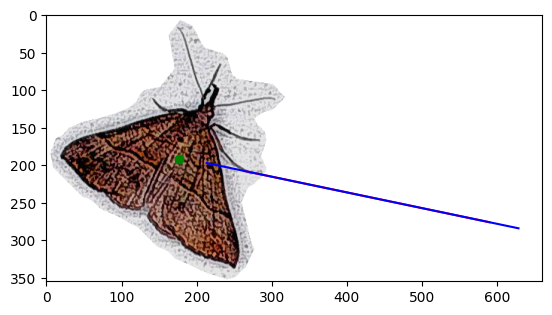

(237, 301)

In [78]:
process_image(image_path)